<a href="https://colab.research.google.com/github/TheoMonpouet/DD2365/blob/main/Project_file_with_Brinkman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project by: Théo Monpouet**

# **Set up environment**

In [ ]:

# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt


#**Domain definition**

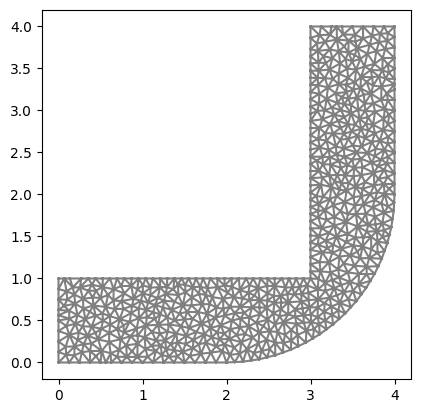

In [ ]:
L = 4
B = 1


class Wall(SubDomain):
  def inside(self, x, on_boundary):
    # if near(x[0], 0.0) and (near(x[1], B) or near(x[1], 0.0)):
    #   return on_boundary

    return on_boundary and not (near(x[0], 0.0) or near(x[1], L))

class Inlet(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0], 0.0)# and not (near(x[1], B) or near(x[1], 0.0))

class Outlet(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], L)


wall = Wall()
inlet = Inlet()
outlet = Outlet()



resolution = 32


# Sharp edges
# domain = Rectangle(Point(0.0,0.0), Point(L,B)) + \
#          Rectangle(Point(L-B,L), Point(L, B))

# Rounded inner corner
# domain = Rectangle(Point(0.0, 0.0), Point(L, B)) + \
#          Rectangle(Point(L - B, L), Point(L, B)) + \
#          Rectangle(Point(L - 2*B, 2*B), Point(L - B, B)) - \
#          Circle(Point(L - 2*B, 2*B), B, resolution*2)

# Rounded outer corner
domain = Rectangle(Point(0.0, 0.0), Point(L-B-B, B)) + \
         Rectangle(Point(L - B, L), Point(L, 2*B)) + \
         Circle(Point(L - 2*B, 2*B), 2*B, resolution*2) - \
         Rectangle(Point(0, L), Point(L-B, B))
        #  Rectangle(Point(L - 2*B, 2*B), Point(L - B, B)) - \
        #  Circle(Point(L - 2*B, 2*B), B, resolution*2)



# Rounded both corner
# domain = Rectangle(Point(0.0, 0.0), Point(L-B-B, B)) + \
#          Rectangle(Point(L - B, L), Point(L, 2*B)) + \
#          Circle(Point(L - 2*B, 2*B), 2*B, resolution*2) - \
#          Rectangle(Point(0, L), Point(L-B, B)) + \
#          Rectangle(Point(L - 2*B, 2*B), Point(L - B, B)) - \
#          Circle(Point(L - 2*B, 2*B), B, resolution*2)

# Channel
# domain = Rectangle(Point(0.0, 0.0), Point(L-B-B, B)) + \
#          Rectangle(Point(L - B, L), Point(L, 2*B)) + \
#          Circle(Point(L - 2*B, 2*B), 2*B, resolution*2) - \
#          Rectangle(Point(0, L), Point(L-B, B)) + \
#          Rectangle(Point(L - 2*B, 2*B), Point(L - B, B)) - \
#          Circle(Point(L - 2*B, 2*B), B, resolution*2) - (Circle(Point(L-2*B, 2*B), 2*B - B/2+0.05, resolution*2) - Circle(Point(L-2*B, 2*B), 2*B - B/2-0.05, resolution*2) - Rectangle(Point(L-B, 4*B), Point(L, 2*B))- Rectangle(Point(L-4*B, B), Point(L-2*B, 0.0)))


# domain2 = Circle(Point(L-2*B, 2*B), 2*B - B/5) - Circle(Point(L-2*B, 2*B), 2*B - 2*(B/6))


mesh = generate_mesh(domain, resolution)
# mesh2 = generate_mesh(domain2, resolution)



plt.figure()
plot(mesh)

# plt.figure()
# plot(mesh2)

plt.show()



**Refining mesh**

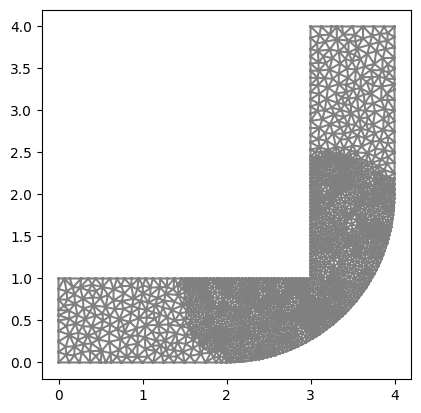

In [ ]:
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    # if p.distance(Point(L-B-0.3, B+0.5)) < 1.3 or (p[1] < 1.1 and p[1] > 0.9):
    if p.distance(Point(L-B, B)) < 1.5 and i == 0:# or (p[1] < 1.1 and p[1] > 0.9):
      cell_marker[cell] = True
    if p.distance(Point(L-B, B)) < 0.2 and i == 1:# or (p[1] < 1.1 and p[1] > 0.9):
      cell_marker[cell] = True


  mesh = refine(mesh, cell_marker)



# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
wall.mark(boundaries, 1)
inlet.mark(boundaries, 2)
outlet.mark(boundaries, 3)


# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

plt.figure()
plot(mesh)

plt.show()

# **Boundary conditions**

In [ ]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

In [ ]:
# Define boundary conditions

# class wallBC(SubDomain):
#   def inside(self, x, on_boundary):
#     if near(x[0], 0.0) and (near(x[1], B) or near(x[1], 0.0)):
#       return on_boundary

#     return on_boundary and not (near(x[0], 0.0) or near(x[1], L))

class inletBC(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0], 0.0)# and not (near(x[1], B) or near(x[1], 0.0))

class outletBC(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], L)


uin = 1
nu = 4.0e-6

bc_inlet_x = DirichletBC(V.sub(0), uin, inletBC())
bc_inlet_y = DirichletBC(V.sub(1), 0.0, inletBC())

# bc_wall_x = DirichletBC(V.sub(0), 0.0, wallBC())
# bc_wall_y = DirichletBC(V.sub(1), 0.0, wallBC())


bc_outlet = DirichletBC(Q, 0.0, outletBC())


# bcu = [bc_wall_x, bc_wall_y, bc_inlet_x, bc_inlet_y]
bcu = [bc_inlet_x, bc_inlet_y]
bcp = [bc_outlet]


# **Functions and variational problem**

In [ ]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin() # ändra 0.5

In [ ]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 4.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = 2.0*h*u_mag

# Skin friction boundary conditions, implemented as
# penalty terms, defined in terms
# of the normal and tangent vectors
normal = FacetNormal(mesh)
tangent = as_vector([normal[1], -normal[0]])
C_alpha = 1.0e2
alpha = C_alpha/h
beta = 0.5
# beta = 10

# Smagorinsky model (simplified)
C_t = 1.0

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + C_t*h*h*sqrt(inner(grad(um1), grad(um1)))*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx \
    + alpha*(inner(dot(um,normal), dot(v,normal)))*ds(1) + beta*(inner(dot(um,tangent), dot(v,tangent)))*ds(1)
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)


# **Plot and save result**

In [ ]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 200

time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

In [ ]:
!rm results-NS/*

# Time stepping
T = 5
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t)
    #print(s)

    # pin.t = t
    #uin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        k += 1

    if t > plot_time:

        s = 'Time t = ' + repr(t)
        print(s)

        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        # plt.figure()
        # plot(p1, title="Pressure")

        plot_time += T/plot_freq

        plt.show()



    # Update time step
    u0.assign(u1)
    t += dt

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')